# Variational Bayes Notes

## What is variational Bayes?
A technique that allows us to compute approximations to non-closed form Bayes update equations.

## Why would we use it?
In **Bayesian parameter estimation**, to compute the intractable integration of the denominator in the parameter posterior probability:

\begin{equation}
p(\Theta \vert \Omega, Y) = \frac{p(Y, \Theta \vert \Omega)}{\int p(Y, \Theta \vert \Omega) d\Omega}
\end{equation}

and in **Bayesian model fitting**, to find the denominator of the model posterior probability (for a fixed $\Omega$):

\begin{equation}
p(\Omega \vert Y) = \frac{p(Y \vert \Omega) p( \Omega )}{\sum_{\Omega \in \mathcal{M}} p(Y\vert \Omega)p(\Omega)}
\end{equation}

Where $\Omega$ is the candidate model, $Y = \{(x_1,d_1),\dots,(x_N,d_N)\}$ is the training data, $\Theta$ is the set of unknown model parameters (and prior hyperparameters) under $\Omega$.

Also for **Bayesian data fusion**, if we're using GMM priors with MMS likelihoods, we're trying to evaluate

\begin{equation}\label{eq:bdf}
p(X_k \vert D_k) = \frac{P(D_k \vert X_k) p( X_k )}{\int P(D_k \vert X_k) p( X_k )dX_k} = \frac{p(X_k,D_k)}{P(D_k)}
\end{equation}


Where $p(D_k \vert X_k)$ is the MMS model and 

$$
p( X_k ) = p(X_{k} \vert D_{1:k-1}) = \int p(X_k \vert X_{k-1}) p(X_{k} \vert D_{1:k-1}) dX_{k-1}
$$

where $p(X_k \vert X_{k-1})$ is the state transition pdf and we are only fusing $D_k$ sensor data.

## Alternatives & Extensions
 * Grid-based approaches
 * [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (and other Monte Carlo/Particle Filter techniques)
 * [Laplace Approximation](https://en.wikipedia.org/wiki/Laplace's_method)
 * VBIS: Use variational bayes outputs as the parameters for imporance distribution $q(X_k)$
 * LWIS: Use prior $p(X_k)$ as imporance distribution $q(X_k)$
 

## How does it work?

VB minimizes the KLD between the integrable, closed-form *variational posterior* parameter distribution $q(\Theta \vert Y, \Omega)$ and the true posterior $p(\Theta \vert \Omega, Y)$ for $\Omega \in \mathcal{M}$:

$$
KL(q\vert\vert p) = - \int q(\Theta \vert Y, \Omega) log{\frac{p(\Theta \vert Y, \Omega)}{q(\Theta \vert Y, \Omega)}}d\Theta
$$

But, since $p(\Theta \vert Y, \Omega)$ is unavailable, we can instead minimize the KLD by maximizing a lower bound $\mathcal{L}$ to $\log{p(Y\vert\Omega)}$, where:

$$
\mathcal{L} = \int q(\Theta \vert Y, \Omega) log{\frac{p(Y, \Omega \vert \Theta)}{q(\Theta \vert Y, \Omega)}}d\Theta
$$

and

\begin{align*}
\log{p(Y\vert\Omega)} &= \mathcal{L} + KL(q \vert\vert p) \\
&= \int q(\Theta \vert Y, \Omega) log{\frac{p(Y, \Omega \vert \Theta)}{q(\Theta \vert Y, \Omega)}}d\Theta 
- \int q(\Theta \vert Y, \Omega) log{\frac{p(\Theta \vert Y, \Omega)}{q(\Theta \vert Y, \Omega)}}d\Theta \\
&= \int q(\Theta \vert Y, \Omega) log{(p(Y, \Omega \vert \Theta))}
- q(\Theta \vert Y, \Omega) log{(p(\Theta \vert Y, \Omega))}d\Theta \\
&= \int q(\Theta \vert Y, \Omega) log{\frac{p(Y, \Omega \vert \Theta)}{p(\Theta \vert Y, \Omega)}}
d\Theta
\end{align*}

## How do we use it?

Take equation \ref{eq:bdf}. We want to approximate $p(X_k,D_k)$ (analytically intractable) with an unnormalized Gaussian lower bound pdf, which leads to a *variational Bayesian* Gaussian posterior approximation $\hat{p}(X_k\vert D_k)$.

If $f(D_k,X_k)$ is an unnormalized Gaussian function that approximates the softmax likelihood $P(D_k \vert X_k)$, then

\begin{align}\label{eq:approx_joint}
p(X_k,D_k) &\approx \hat{p}(X_k,D_k) = p(X_k)f(D_k,X_k) \\
P(D_k) = C &\approx \hat{C} = \int_{-\infty}^{\infty} \hat{p}(X_k,D_k)
\end{align}
 
Since $p(X_k)$ is Gaussian, $\hat{p}(X_k,D_k)$ is as well (as the product of two gaussians).

### How do we derive $f(D_k,X_k)$?

[2] derives an upper bound to the softmax denominator:

\begin{equation}\label{eq:upper}
\log\left(\sum_{c=1}^m e^{y_c}\right) \leq \alpha + \sum_{c=1}^m \frac{y_c - \alpha - \xi_c}{2} + \lambda(\xi_c)[(y_c - \alpha)^2 - \xi_c^2] + log(1 + e^{\xi_c})
\end{equation}

where $\lambda(\xi_c) = \frac{1}{2\xi_c}\left[\frac{1}{1 + e^{-\xi_c}}\right] - \frac{1}{2}$ and $y_c = w^T_cx + b_c$. $\alpha$ and $\xi_c$ are *free variational parameters*; given $y_c$, $\alpha$ and $\xi_c$ can be selected to minimize the upper bound in \ref{eq:upper}.

Assuming known $\alpha$ and $\xi_c$, we take the log of the softmax likelihood to get:

\begin{align*}
\log{P(D_k=j\vert X_k)} &= w^T_jx + b_j - \log{\left(\sum_{c=1}^m e^{w^T_cx + v_c}\right)} \\
&\leq \log{f(D_j=j,X_k)} =  g_j + h^T_jx - \frac{1}{2}x^TK_jx
\end{align*}

Where

\begin{equation}\label{eq:approx_likelihood}
f(D_j=j,X_k) = \exp\{g_j + h^T_jx - \frac{1}{2}x^TK_jx\}
\end{equation}

The prior $p(X_k)$ can be expressed similarly:

\begin{equation}\label{eq:gaussian_prior}
p(X_k) = \exp\{g_p + h^T_px - \frac{1}{2}x^TK_px\}
\end{equation}

where $g_p = -\frac{1}{2}(log{\lvert2\pi\Sigma\rvert} + \mu^TK_p\mu)$, $h_p = K_p\mu$ $K_p = \Sigma^{-1}$. This is simply a reformulation of the equation of a gaussian:

\begin{align*}
p(X_k) &= \frac{1}{\sqrt{\lvert 2 \pi \Sigma \rvert}} exp{\{-\frac{1}{2}(x - \mu)^T\Sigma^{-1}(x - \mu) \}} \\
&=exp{\{-\frac{1}{2}(x^T - \mu^T)K_p(x - \mu) -\frac{1}{2}\log{\lvert 2 \pi \Sigma \rvert} \}}\\
&=exp{\{-\frac{1}{2}x^TK_px +\frac{1}{2}(x^TK_p\mu +\mu^TK_px) -\frac{1}{2}\mu^TK_p\mu -\frac{1}{2}\log{\lvert 2 \pi \Sigma \rvert} \}}\\
&=exp{\{-\frac{1}{2}(\log{\lvert 2 \pi \Sigma \rvert} + \mu^TK_p\mu ) +\frac{1}{2}(K_p\mu x +K_p \mu x) -\frac{1}{2}x^TK_px \}}\\
&= \exp\{g_p + h^T_px - \frac{1}{2}x^TK_px\}
\end{align*}

Since equation \ref{eq:approx_joint} is simply the product of two Gaussians, it becomes:

\begin{equation}\label{eq:approx_joint_product}
\hat{p}(X_k,D_k) = p(X_k)f(D_k,X_k) = \exp\{g_l + h^T_lx - \frac{1}{2}x^TK_lx\} = \mathcal{N}(\hat{\mu}_{VB},\hat{\Sigma}_{VB})
\end{equation}

### But how do we optimize $\alpha$ and $\xi_c$ ?

Minimizing the RHS of \ref{eq:upper} gives us:

\begin{align}
\xi^2_c &= y^2_c + \alpha^2 - 2\alpha y_c \label{eq:xi} \\ 
\alpha &= \frac{\left(\frac{m-2}{4}\right) \sum_{c=1}^m\lambda(\xi_c)y_c}{\sum_{c=1}^m\lambda(\xi_c)} \label{eq:alpha}
\end{align}

But, both depend on $X_k$, which is unobserved. Instead, we minimize the *expected value* of the RHS of \ref{eq:upper} with respect to the posterior.

Apparently **(?)** this is equivalent to maximizing $\log{\hat{P}(D_k)}$, the *approximate* the marginal log-likelihood of the observation $D_k = j$:

$$
\log{\hat{P}(D_k)} = \log{\hat{C}} = \log \int_{-\infty}^{\infty} \hat{p}(X_k,D_k)dX_k
$$

We can now use **expectation-maximization (EM)** to iteratively optimize $\alpha$ and $\xi_c$. We take the expectations of \ref{eq:xi} and \ref{eq:alpha} under the current $\hat{p}(X_k \vert D_k)$ estimate. Additionally, we'll need the following:

\begin{align}
\langle y_c\rangle &= w^T_c\hat{\mu}_{VB} + b_c \label{eq:y_expected} \\ 
\langle y^2_c\rangle &= w^T_c(\hat{\Sigma}_{VB} + \hat{\mu}_{VB}\hat{\mu}_{VB}^T)w_c + 2w^T_c\hat{\mu}_{VB}b_c + b^2_c \label{eq:y2_expected}
\end{align}

The code below demonstrates the expectation maximization algorithm.

## Issues

The approximate posterior is **optimistic** relative to the true posterior, and will be biased due to this optimism as well.


# Examples

## Variational Bayes (VB) with Softmax and Gaussian Prior

Let's restate the bayesian data fusion problem. We want to compute the following:

\begin{equation}\label{eq:vb-bdf}
p(X_k \vert D_k) = \frac{P(D_k = j \vert X_k) p( X_k )}{\int P(D_k = j \vert X_k) p( X_k )dX_k} = \frac{p(X_k,D_k)}{P(D_k)}
\end{equation}

Where, for a softmax likelihood,

\begin{equation}\label{eq:softmax}
P(D_k = j \vert X_k) = \frac{e^{w^T_jx + b_j}}{\sum_{c=1}^m e^{w^T_cx + b_c}}
\end{equation}

and, for a gaussian prior, 

\begin{equation}
P(X_k) = \frac{1}{\sqrt{\lvert 2 \pi \Sigma}} \exp{\{-\frac{1}{2}(x - \mu)^T\Sigma^{-1}(x - \mu)\}}
\end{equation}

We show these two below for a one-dimensional problem of estimating the speed of a target.

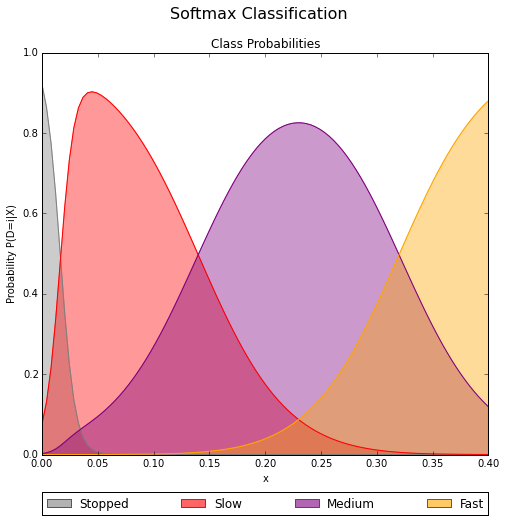

In [1]:
from cops_and_robots.robo_tools.fusion.softmax import speed_model
%matplotlib inline

sm = speed_model()
sm.plot(plot_classes=False)

0.3
0.01


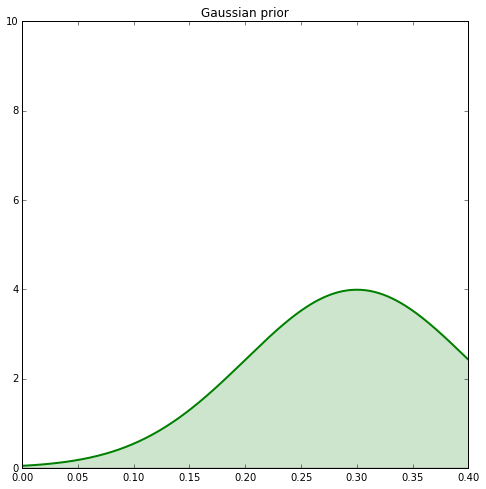

In [63]:
from __future__ import division
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

mu = 0.3
sigma = 0.1
min_x = -5
max_x = 5
res = 10000

prior = norm(loc=mu, scale=sigma)
x_space = np.linspace(min_x, max_x, res)

# Plot the frozen distribution
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8)
ax.plot(x_space, prior.pdf(x_space), lw=2, label='frozen pdf', c='g')
ax.fill_between(x_space, 0, prior.pdf(x_space), alpha=0.2, facecolor='g')
ax.set_xlim([0,.4])
ax.set_ylim([0,10])
ax.set_title('Gaussian prior')

While the numerator of \ref{eq:vb-bdf} can be computed easily, there is no closed form solution for its denominator. 

We'll follow the following algorithm:

**Inputs**
 * prior $\mu$ and $\Sigma$; 
 * $D_k = j$ with likelihood in eq.(7);
 * initial $\alpha$ and $\xi_c$, for j, c ∈ {1, ...,m}

**Outputs**
 * posterior mean $\hat{\mu}_{VB}$
 * Posterior covariance $\hat{\Sigma}_{VB}$
 
**Steps**
 1. E-step: for all fixed $\xi_c$ and $\alpha$, 
   1. compute $\hat{\alpha}_{VB}$ and $\hat{\Sigma}_{VB}$ via eq. (19);
   2. compute $\langle y_c\rangle$ and $\langle y_c^2\rangle$ via eqs. (23)-(24);
 2. M-step: for all fixed $\langle y_c\rangle$ and $\langle y_c^2\rangle$, <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**for $i = 1 : n_{lc}$ do **
   1. compute all $\xi_c$ for fixed $\alpha$ via eq. (20)
   2. compute $\alpha$ for all fixed $\xi_c$ via eq. (21) <br />
**end for **
 3. If converged, return $\hat{C}$ via eq. (25) and stop; otherwise, return to step 1

Mu and sigma found to be 0.226054365609 and 5.55717158938e-05, respectively.


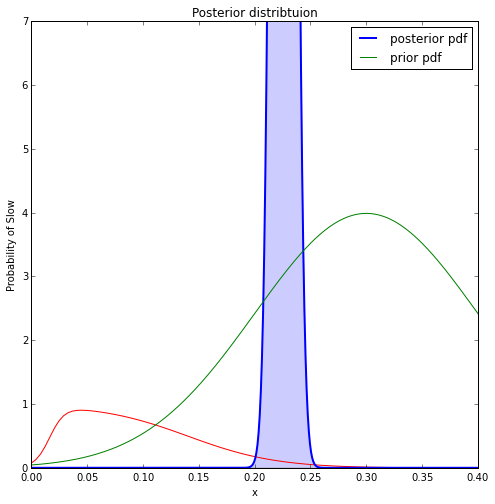

In [60]:
from numpy.linalg import inv
import pandas as pd
np.set_printoptions(precision=2, suppress=True)
pd.set_option('precision', 3)

# SETTINGS:
n_lc = 15  # number of convergence loops
measurement = 'Medium'
tolerance = 10 ** -3  # for convergence
max_EM_steps = 1000


# INPUT: Define input priors and initial values
prior_mu = np.zeros(1)
prior_sigma = np.array([[1]])
initial_alpha = 0.5
initial_xi = np.ones(4)

# Softmax values
m = 4
w = sm.weights
b = sm.biases
j = sm.class_labels.index(measurement)

# Preparation
xis = initial_xi
alpha = initial_alpha
mu_hat = prior_mu
sigma_hat = prior_sigma


# dataframe for debugging
df = pd.DataFrame({'Alpha': alpha,
                   'g_j' : np.nan,
                   'h_j' : np.nan,
                   'K_j' : np.nan,                   
                   'Mu': mu_hat[0],
                   'Sigma': sigma_hat[0][0],
                   'Xi': [xis],
                   })
def lambda_(xi_c):
    return 1 / (2 * xi_c) * ( (1 / (1 + np.exp(-xi_c))) - 0.5)


converged = False
EM_step = 0

while not converged and EM_step < max_EM_steps:
    ################################################################
    # STEP 1 - EXPECTATION
    ################################################################
    # PART A #######################################################

    # find g_j
    sum1 = 0
    for c in range(m):
        if c != j:
            sum1 += b[c]
    sum2 = 0
    for c in range(m):
        sum2 = xis[c] / 2 \
            + lambda_(xis[c]) * (xis[c] ** 2 - (b[c] - alpha) ** 2) \
            - np.log(1 + np.exp(xis[c]))
    g_j = 0.5 *(b[j] - sum1) + alpha * (m / 2 - 1) + sum2

    # find h_j
    sum1 = 0
    for c in range(m):
        if c != j:
            sum1 += w[c]
    sum2 = 0
    for c in range(m):
        sum2 += lambda_(xis[c]) * (alpha - b[c]) * w[c]
    h_j = 0.5 * (w[j] - sum1) + 2 * sum2

    # find K_j
    sum1 = 0
    for c in range(m):
        sum1 += lambda_(xis[c]) * w[c].T .dot (w[c])

    K_j = 2 * sum1
        
    K_p = inv(prior_sigma)
    g_p = -0.5 * (np.log( np.linalg.det(2 * np.pi * prior_sigma))) \
        + prior_mu.T .dot (K_p) .dot (prior_sigma)
    h_p = K_p .dot (prior_mu)

    g_l = g_p + g_j
    h_l = h_p + h_j
    K_l = K_p + K_j

    mu_hat = inv(K_l) .dot (h_l)
    sigma_hat = inv(K_l)
        
    # PART B #######################################################
    y_cs = np.zeros(m)
    y_cs_squared = np.zeros(m)
    for c in range(m):
        y_cs[c] = w[c].T .dot (mu_hat) + b[c]
        y_cs_squared[c] = w[c].T .dot (sigma_hat + mu_hat .dot (mu_hat.T)) .dot (w[c]) \
            + 2 * w[c].T .dot (mu_hat) * b[c] + b[c] ** 2

    ################################################################
    # STEP 2 - MAXIMIZATION
    ################################################################
    for i in range(n_lc):

        # PART A #######################################################
        # Find xi_cs
        for c in range(m):
            xis[c] = np.sqrt(y_cs_squared[c] + alpha ** 2 - 2 * alpha * y_cs[c])

        # PART B #######################################################
        # Find alpha
        num_sum = 0
        den_sum = 0
        for c in range(m):
            num_sum += lambda_(xis[c]) * y_cs[c]
            den_sum += lambda_(xis[c])
        alpha = ((m - 2) / 4 + num_sum) / den_sum

    ################################################################
    # STEP 3 - CONVERGENCE CHECK
    ################################################################    
    
    new_df = pd.DataFrame([[alpha, g_j, h_j, K_j, mu_hat, sigma_hat, 
                            [xis]]],
                          columns=('Alpha','g_j','h_j','K_j','Mu','Sigma',
                                   'Xi',))
    df = df.append(new_df, ignore_index=True)
    EM_step += 1
# df

#plot results
mu_post = mu_hat[0]
sigma_post = np.sqrt(sigma_hat[0][0])

print('Mu and sigma found to be {} and {}, respectively.'.format(mu_hat[0],sigma_hat[0][0]))

ax = sm.plot_class(measurement_i, fill_between=False)
posterior = norm(loc=mu_post, scale=sigma_post)
ax.plot(x_space, posterior.pdf(x_space), lw=2, label='posterior pdf', c='b')
ax.fill_between(x_space, 0, posterior.pdf(x_space), alpha=0.2, facecolor='b')
ax.plot(x_space, prior.pdf(x_space), lw=1, label='prior pdf', c='g')

ax.set_title('Posterior distribtuion')
ax.legend()
ax.set_xlim([0, 0.4])
ax.set_ylim([0, 7])
plt.show()

Correct output: sigma 5.926215694086777e-05 and mu 0.2227

### Comparison: discretized state space

Using a discrete environment, we get the following:

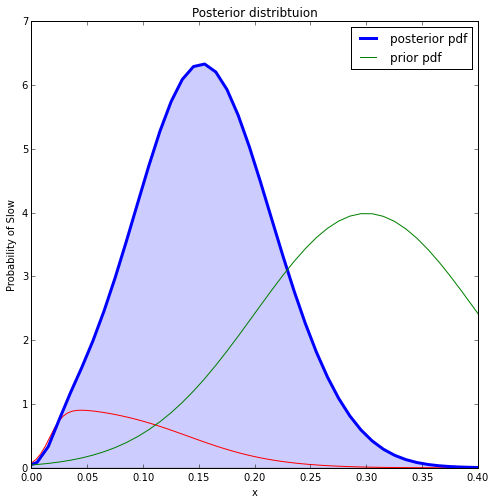

In [23]:
measurement = 'Slow'
measurement_i = sm.class_labels.index(measurement)

dx = (max_x - min_x)/res

normalizer = 0
for x in x_space:
    lh = sm.probs_at_state(x, measurement)
    if np.isnan(lh):
        lh = 1.00
    normalizer += lh  * gaussian.pdf(x)
normalizer *= dx
    
posterior = np.zeros_like(x_space)
for i, x in enumerate(x_space):
    lh = sm.probs_at_state(x, measurement)
    if np.isnan(lh):
        lh = 1.00
    posterior[i] = lh * gaussian.pdf(x) / normalizer
    
ax = sm.plot_class(measurement_i, fill_between=False)
ax.plot(x_space, posterior, lw=3, label='posterior pdf', c='b')
ax.fill_between(x_space, 0, posterior, alpha=0.2, facecolor='b')
ax.plot(x_space, prior.pdf(x_space), lw=1, label='prior pdf', c='g')

ax.set_title('Posterior distribtuion')
ax.legend()
ax.set_xlim([0, 0.4])
plt.show()

## References
[1] N. Ahmed and M. Campbell, “Variational Bayesian learning of probabilistic discriminative models with latent softmax variables,” Signal Process. IEEE Trans. …, vol. XX, no. c, pp. 1–27, 2011.

[2] G. Bouchard, “Efficient bounds for the softmax function and applications to approximate inference in hybrid models,” in NIPS 2007 Workshop for Approximate Bayesian Inference in Continuous/Hybrid Systems, Whistler, BC, Canada, 2007.

[3] N. Ahmed, E. Sample, and M. Campbell, “Bayesian Multicategorical Soft Data Fusion for Human--Robot Collaboration,” IEEE Trans. Robot., vol. 29, no. 1, pp. 189–206, 2013.

In [5]:
from IPython.core.display import HTML

# Borrowed style from Probabilistic Programming and Bayesian Methods for Hackers
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()